  # ** GLOBAL SETTINGS **

In [1]:
# python peripherals
import random
import os
import sys
import math
sys.path.insert(1, os.path.join(sys.path[0], '../..'))

# numpy
import numpy

# pandas
import pandas

# ipython
from IPython.display import display, HTML

# matplotlib
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.lines

# pytorch
import torch
from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.data.sampler import SequentialSampler
from torch.utils.data import DataLoader

# deep signature
from deep_signature.utils import utils
from deep_signature.data_generation.curve_generation import LevelCurvesGenerator
from deep_signature.data_manipulation import curve_processing
from deep_signature.nn.datasets import DeepSignatureTupletsDataset
from deep_signature.nn.networks import DeepSignatureArcLengthNet
from deep_signature.nn.networks import DeepSignatureCurvatureNet
from deep_signature.nn.losses import ContrastiveLoss
from deep_signature.nn.trainers import ModelTrainer
from deep_signature.data_manipulation import curve_sampling
from deep_signature.data_manipulation import curve_processing
from deep_signature.linalg import euclidean_transform
from deep_signature.linalg import affine_transform

# common
from common import settings
from common import utils as common_utils

# notebooks
from notebooks.utils import utils as notebook_utils


  # ** IMPORT PACKAGES **

In [2]:
# plt.style.use("dark_background")

transform_type = 'equiaffine'

if transform_type == 'euclidean':
    level_curves_arclength_tuplets_dir_path = settings.level_curves_euclidean_arclength_tuplets_dir_path
    level_curves_arclength_tuplets_results_dir_path = settings.level_curves_euclidean_arclength_tuplets_results_dir_path
elif transform_type == 'equiaffine':
    level_curves_arclength_tuplets_dir_path = settings.level_curves_equiaffine_arclength_tuplets_dir_path
    level_curves_arclength_tuplets_results_dir_path = settings.level_curves_equiaffine_arclength_tuplets_results_dir_path

if transform_type == 'euclidean':
    level_curves_curvature_tuplets_dir_path = settings.level_curves_euclidean_curvature_tuplets_dir_path
    level_curves_curvature_tuplets_results_dir_path = settings.level_curves_euclidean_curvature_tuplets_results_dir_path
elif transform_type == 'equiaffine':
    level_curves_curvature_tuplets_dir_path = settings.level_curves_equiaffine_curvature_tuplets_dir_path
    level_curves_curvature_tuplets_results_dir_path = settings.level_curves_equiaffine_curvature_tuplets_results_dir_path


  # ** CURVES **

In [3]:
# curves = LevelCurvesGenerator.load_curves(dir_path=settings.level_curves_dir_path_train)
# limit = 10
# color_map = plt.get_cmap('rainbow', limit)
# for i, curve in enumerate(curves[:limit]): 
#     fig, ax = plt.subplots(1, 1, figsize=(80,40))
#     for label in (ax.get_xticklabels() + ax.get_yticklabels()):
#         label.set_fontsize(30)
#     ax.axis('equal')
#     notebook_utils.plot_curve(ax=ax, curve=curve, linewidth=5)
#     plt.show()


  # ** LEARNING CURVE **

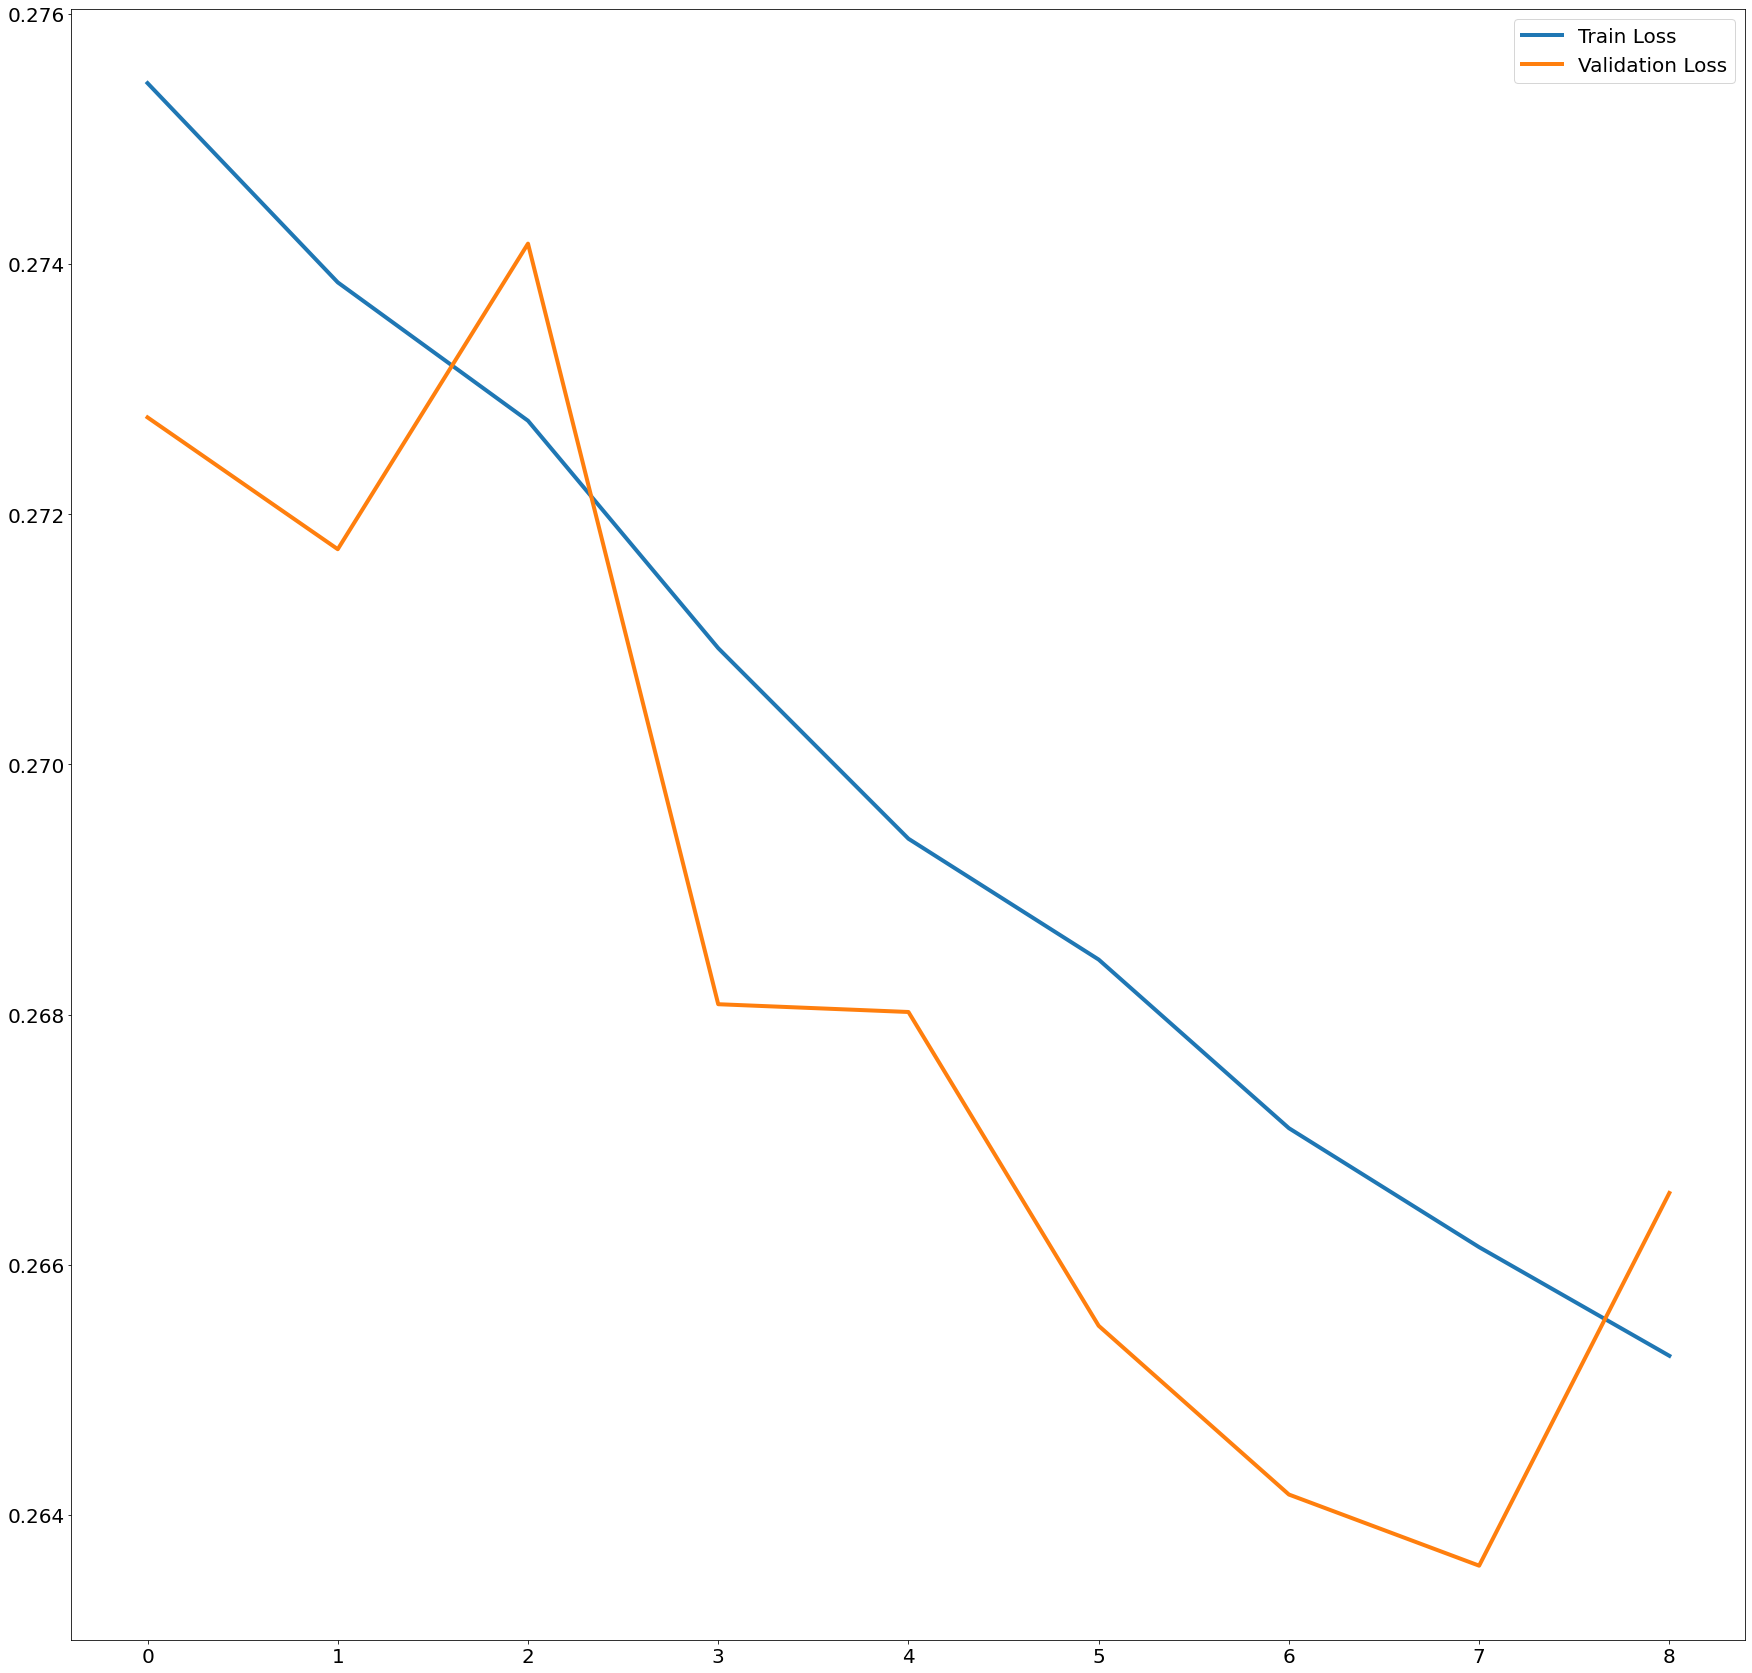

In [11]:
latest_subdir = common_utils.get_latest_subdirectory(level_curves_curvature_tuplets_results_dir_path)
results = numpy.load(f"{latest_subdir}/results.npy", allow_pickle=True).item()

# results2 = numpy.load(f"C:/deep-signature-data/level-curves/results/tuplets/arclength/2021-01-14-02-42-52/results.npy", allow_pickle=True).item()

epochs = results['epochs']
batch_size = results['batch_size']
train_loss_array = results['train_loss_array'][1:]
validation_loss_array = results['validation_loss_array'][1:]

# train_loss_array2 = results2['train_loss_array']
# validation_loss_array2 = results2['validation_loss_array']

epochs_list = numpy.array(range(len(train_loss_array)))
# epochs_list2 = numpy.array(range(len(train_loss_array2)))

fig, ax = plt.subplots(1, 1, figsize=(30,30))
ax.xaxis.set_major_locator(ticker.MaxNLocator(integer=True))

for label in (ax.get_xticklabels() + ax.get_yticklabels()):
    label.set_fontsize(20)

ax.plot(epochs_list, train_loss_array, label='Train Loss', linewidth=4.0)
ax.plot(epochs_list, validation_loss_array, label='Validation Loss', linewidth=4.0)

# ax.plot(epochs_list2, train_loss_array2, label='Train Loss2', linewidth=4.0)
# ax.plot(epochs_list2, validation_loss_array2, label='Validation Loss2', linewidth=4.0)

plt.legend(fontsize=20, title_fontsize=20)

# print(train_loss_array)
# print(validation_loss_array)
plt.show()

  # ** ARC-LENGTH **

## INITIALIZATION ##

In [13]:
# constants
limit = 3
arclength_sample_points = 40
curvature_supporting_points_count = 6
curvature_sample_points = 2 * curvature_supporting_points_count + 1
arclength_step = 40
curvature_step = 1
comparision_curves_count = 1
device = torch.device('cuda')

# if we're in the equiaffine case, snap 'step' to the closest mutiple of 3 (from above)
# if transform_type == "equiaffine":
#     step = int(3 * numpy.ceil(step / 3))

# package settings
torch.set_default_dtype(torch.float64)
numpy.random.seed(60)

# create models
arclength_model = DeepSignatureArcLengthNet(sample_points=arclength_sample_points).cuda()
curvature_model = DeepSignatureCurvatureNet(sample_points=curvature_sample_points).cuda()

# load arclength model state
latest_subdir = common_utils.get_latest_subdirectory(level_curves_arclength_tuplets_results_dir_path)
results = numpy.load(f"{latest_subdir}/results.npy", allow_pickle=True).item()
arclength_model.load_state_dict(torch.load(results['model_file_path'], map_location=device))
arclength_model.eval()

# load curvature model state
latest_subdir = common_utils.get_latest_subdirectory(level_curves_curvature_tuplets_results_dir_path)
results = numpy.load(f"{latest_subdir}/results.npy", allow_pickle=True).item()
curvature_model.load_state_dict(torch.load(results['model_file_path'], map_location=device))
curvature_model.eval()

# load curves (+ shuffle)
curves = LevelCurvesGenerator.load_curves(dir_path=settings.level_curves_dir_path_train)
numpy.random.shuffle(curves)
curves = curves[:limit]

# create color map
color_map = plt.get_cmap('rainbow', limit)


  ## ** EVALUATE ARC-LENGTH **

c:\Users\Roy\Documents\GitHub\deep-signature\notebooks\level_curves\../..\deep_signature\data_manipulation\curve_processing.py:299: RuntimeWarning: invalid value encountered in power
  return S / numpy.power(T, 2/3)


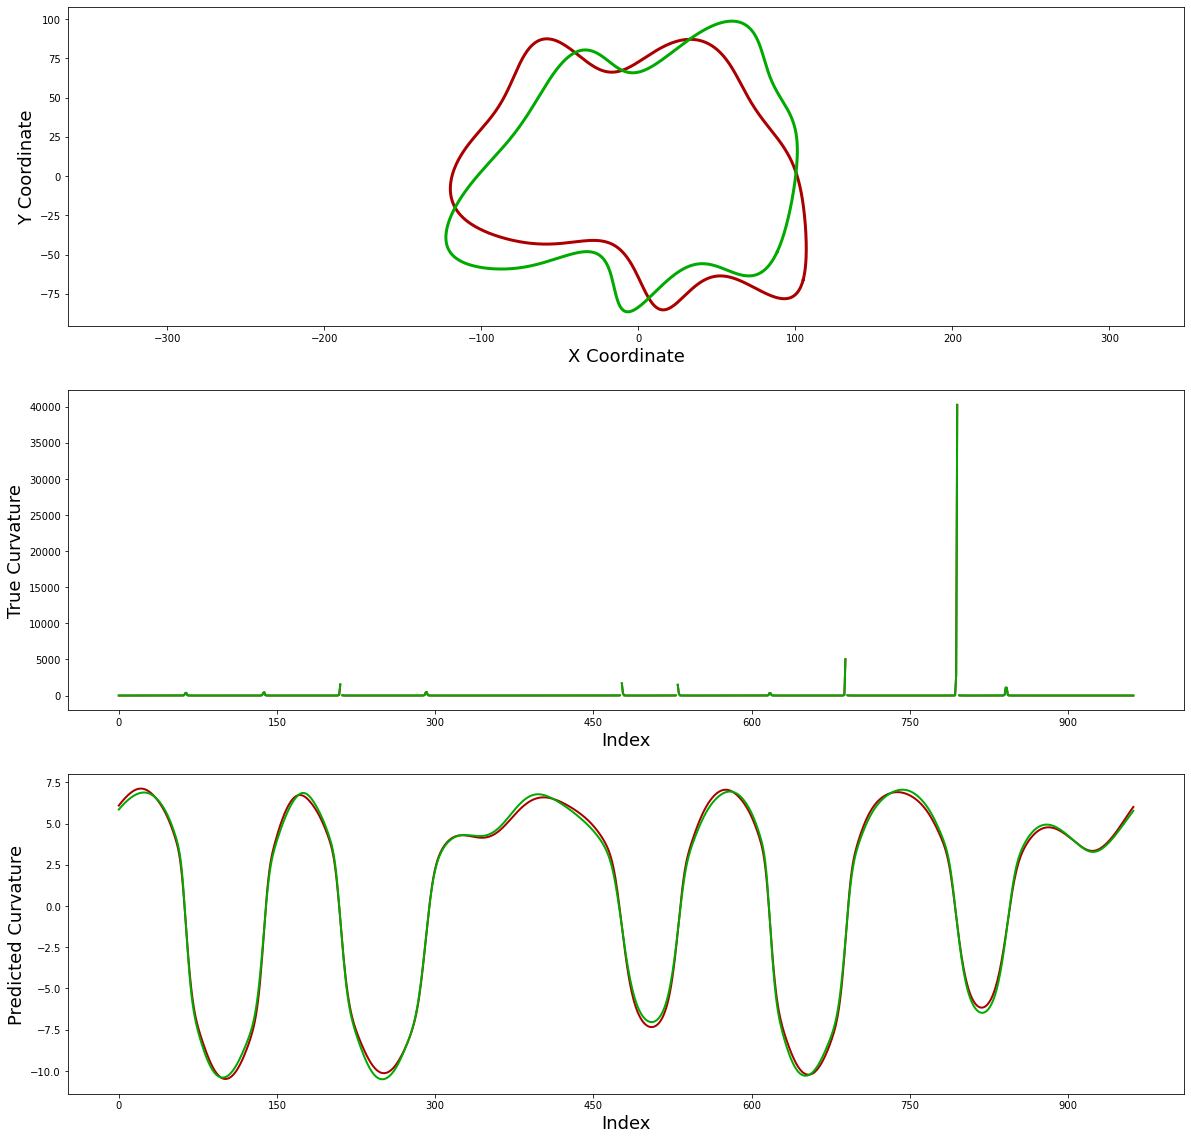

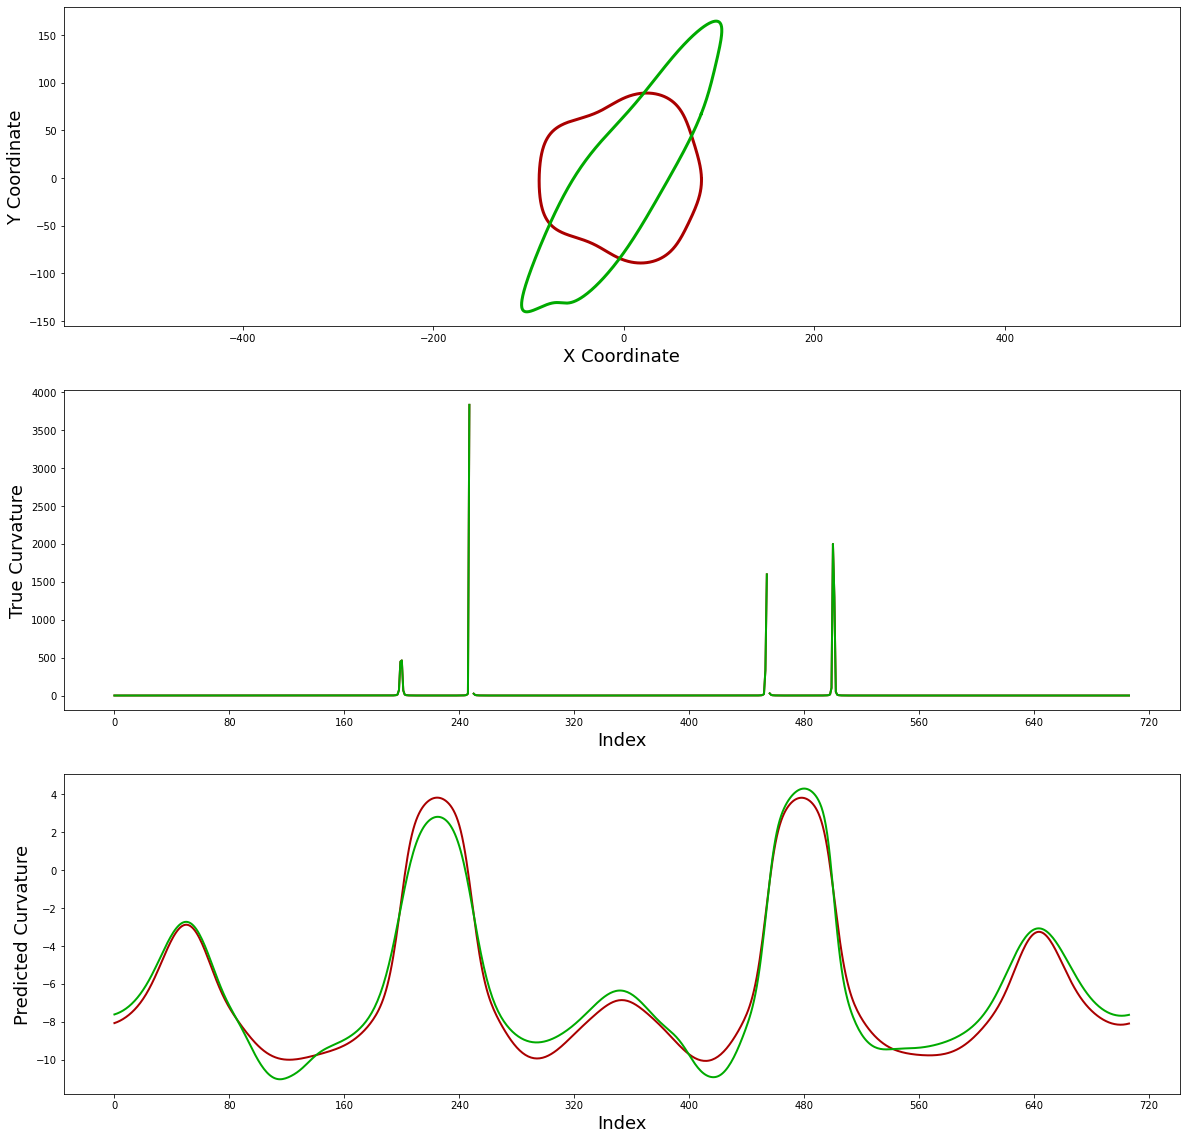

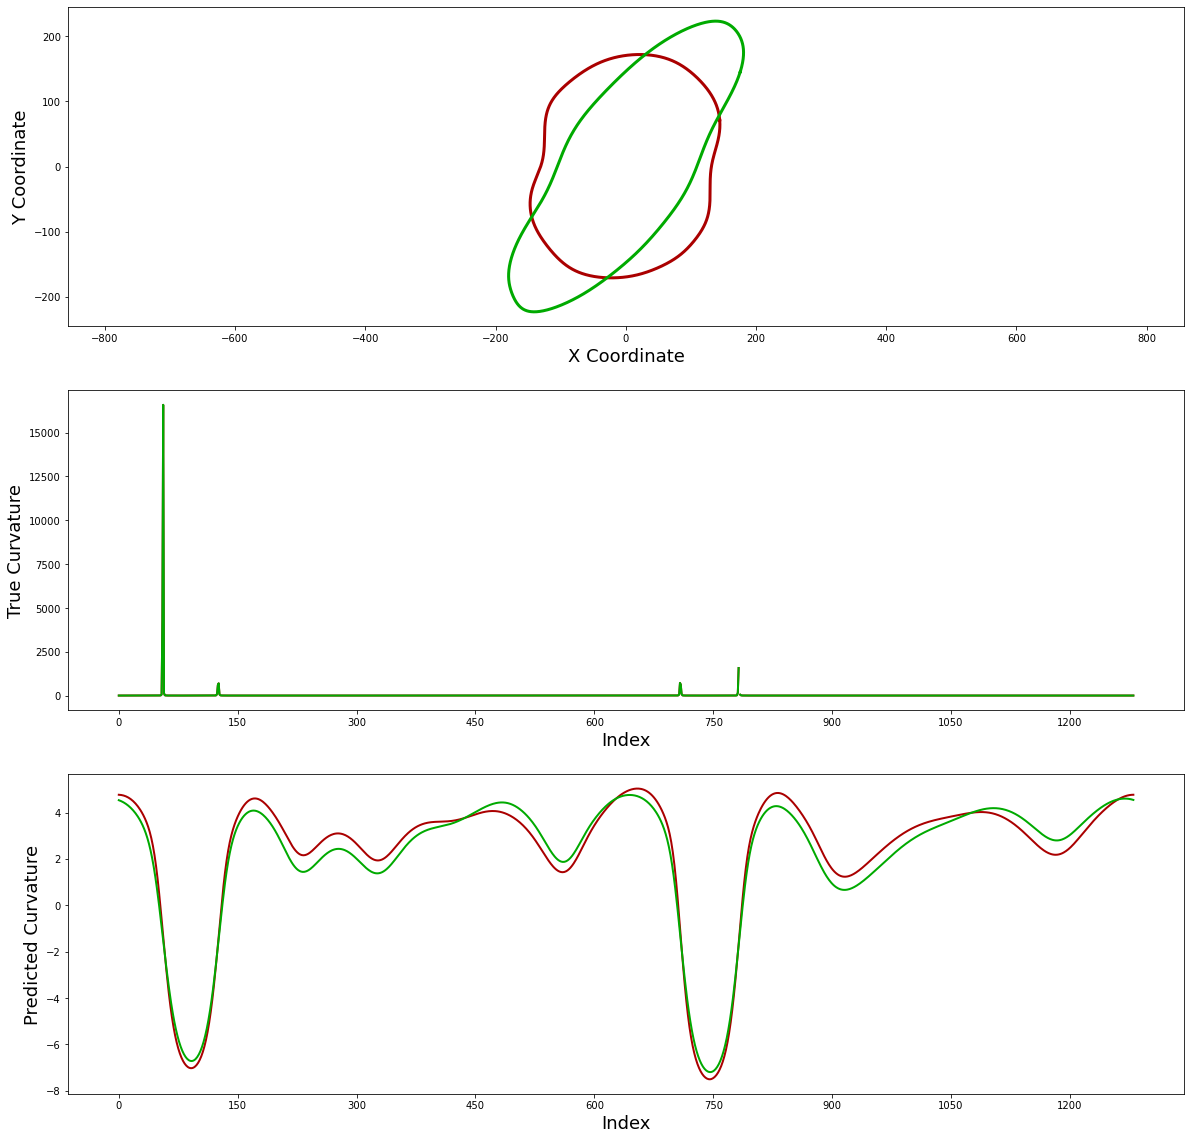

In [14]:
import warnings
warnings.filterwarnings("ignore")

true_arclength_colors = ['#FF8C00', '#444444']
predicted_arclength_colors = ['#AA0000', '#00AA00']
sample_colors = ['#AA0000', '#00AA00']
curve_colors = ['#AA0000', '#00AA00']

curve_records = notebook_utils.generate_curve_records(
    arclength_model=arclength_model,
    curvature_model=curvature_model,
    curves=curves,
    transform_type=transform_type,
    comparision_curves_count=comparision_curves_count,
    arclength_step=arclength_step, 
    curvature_step=curvature_step,
    section_supporting_points_count=arclength_sample_points, 
    neighborhood_supporting_points_count=curvature_supporting_points_count, 
    neighborhood_max_offset=curvature_supporting_points_count)

# notebook_utils.plot_curve_arclength_records(
#     curve_arclength_records=curve_records['curve_arclength_records'], 
#     true_arclength_colors=true_arclength_colors, 
#     predicted_arclength_colors=predicted_arclength_colors, 
#     sample_colors=sample_colors, 
#     curve_color='#FF8C00', 
#     anchor_color='#3333FF', 
#     first_anchor_color='#FF0FF0')

notebook_utils.plot_curve_curvature_records(
    curve_curvature_records=curve_records['curve_curvature_records'], 
    curve_colors=curve_colors)

In [7]:
# sample_points = 13
# supporting_point_count = 6
# max_offset = 6
# limit = 20
# numpy.random.seed(60)

# torch.set_default_dtype(torch.float64)
# device = torch.device('cuda')
# model = DeepSignatureCurvatureNet(sample_points=sample_points).cuda()
# model.load_state_dict(torch.load(results['model_file_path'], map_location=device))
# model.eval()

# curves = LevelCurvesGenerator.load_curves(dir_path=settings.level_curves_dir_path_train)
# numpy.random.shuffle(curves)
# curves = curves[:limit]
# color_map = plt.get_cmap('rainbow', 2*limit)

# for curve_index, curve in enumerate(curves):
#     fig, ax = plt.subplots(3, 1, figsize=(80,100))
#     ax[0].axis('equal')
#     for label in (ax[0].get_xticklabels() + ax[0].get_yticklabels()):
#         label.set_fontsize(30)

#     for label in (ax[1].get_xticklabels() + ax[1].get_yticklabels()):
#         label.set_fontsize(30)

#     for label in (ax[2].get_xticklabels() + ax[2].get_yticklabels()):
#         label.set_fontsize(30)

#     # color-map indices
#     color1_index = curve_index
#     color2_index = 2*limit - curve_index - 1

#     # print(numpy.mean(curve, axis=0))

#     # transform curve
#     if transform_type == 'euclidean':
#         transform = euclidean_transform.random_euclidean_transform_2d()
#     elif transform_type == 'equiaffine':
#         transform = affine_transform.random_equiaffine_transform_2d()

#     transformed_curve = curve_processing.transform_curve(curve=curve, transform=transform)

#     # plot curves
#     notebook_utils.plot_curve(ax=ax[0], curve=curve_processing.translate_curve(curve=curve, offset=-numpy.mean(curve, axis=0)), color=color_map(color1_index), linewidth=5)
#     notebook_utils.plot_curve(ax=ax[0], curve=curve_processing.translate_curve(curve=transformed_curve, offset=-numpy.mean(transformed_curve, axis=0)), color=color_map(color2_index), linewidth=5)

#     # plot predicted curvature
#     predicted_curvature1 = numpy.zeros(curve.shape[0])
#     predicted_curvature2 = numpy.zeros(curve.shape[0])
#     center_index = 1
#     for i in range(curve.shape[0]):
#         sample1 = curve_sampling.sample_curve_point_neighborhood(
#             curve=curve,
#             center_point_index=i,
#             supporting_points_count=supporting_point_count,
#             max_offset=max_offset)

#         sample2 = curve_sampling.sample_curve_point_neighborhood(
#             curve=transformed_curve,
#             center_point_index=i,
#             supporting_points_count=supporting_point_count,
#             max_offset=max_offset)

#         # orig_sample = sample.copy()

#         sample1 = curve_processing.normalize_curve(curve=sample1)
#         sample2 = curve_processing.normalize_curve(curve=sample2)
#         # line1 = numpy.array([[1,1],[1.1,1.1],[1.2,1.2],[1.3,1.3],[1.4,1.4],[1.5,1.5],[1.6,1.6],[1.7,1.7],[1.8,1.8]]) * 1e-40
#         # line1 = curve_processing.normalize_curve(curve=line1)
#         # batch_data_line1 = torch.unsqueeze(torch.unsqueeze(torch.from_numpy(line1).double(), dim=0), dim=0).cuda()
#         # with torch.no_grad():
#         #     zero_curvature = float(torch.squeeze(model(batch_data_line1), dim=0).cpu().detach().numpy())

#         batch_data1 = torch.unsqueeze(torch.unsqueeze(torch.from_numpy(sample1).double(), dim=0), dim=0).cuda()
#         with torch.no_grad():
#             predicted_curvature1[i] = torch.squeeze(model(batch_data1), dim=0).cpu().detach().numpy()

#         batch_data2 = torch.unsqueeze(torch.unsqueeze(torch.from_numpy(sample2).double(), dim=0), dim=0).cuda()
#         with torch.no_grad():
#             predicted_curvature2[i] = torch.squeeze(model(batch_data2), dim=0).cpu().detach().numpy()

#             # kappa = torch.squeeze(model(batch_data), dim=0).cpu().detach().numpy()
#             # adj_kappa = kappa + zero_curvature
#             # if curve_processing.is_ccw(curve=orig_sample):
#             #     predicted_curvature[i] = -adj_kappa
#             # else:
#             #     predicted_curvature[i] = adj_kappa

#     notebook_utils.plot_curvature(ax=ax[1], curvature=predicted_curvature1, color=color_map(color1_index), linewidth=5)
#     notebook_utils.plot_curvature(ax=ax[1], curvature=predicted_curvature2, color=color_map(color2_index), linewidth=5)

#     # plot ground-truth curvature
#     if transform_type == 'euclidean':
#         gt_curvature1 = curve_processing.calculate_euclidean_curvature(curve=curve)
#         gt_curvature2 = curve_processing.calculate_euclidean_curvature(curve=transformed_curve)
#     elif transform_type == 'equiaffine':
#         gt_curvature1 = curve_processing.calculate_equiaffine_curvature(curve=curve)
#         gt_curvature2 = curve_processing.calculate_equiaffine_curvature(curve=transformed_curve)
    
#     # gt_curvature = curve_processing.calculate_curvature(curve=curve)
#     notebook_utils.plot_curvature(ax=ax[2], curvature=gt_curvature1, color='blue', linewidth=5)
#     notebook_utils.plot_curvature(ax=ax[2], curvature=gt_curvature2, color='blue', linewidth=5, alpha=0.5)

#     plt.show()